In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import meta
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions
TWO_STAGE = False

In [2]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
held_in_session_ids=[
    "MonkeyG_20150914_Session1_S1",
    "MonkeyG_20150915_Session3_S1",
    "MonkeyG_20150915_Session5_S1",
    "MonkeyG_20150916_Session4_S1",
    "MonkeyG_20150917_Session1_M1",
    "MonkeyG_20150917_Session1_S1",
    "MonkeyG_20150917_Session2_M1",
    "MonkeyG_20150917_Session2_S1",
    "MonkeyG_20150921_Session3_S1",
    "MonkeyG_20150921_Session5_S1",
    "MonkeyG_20150922_Session1_S1",
    "MonkeyG_20150922_Session2_S1",
    "MonkeyG_20150925_Session1_S1",
    "MonkeyG_20150925_Session2_S1",
    "MonkeyJ_20160426_Session2_S1",
    "MonkeyJ_20160426_Session3_S1",
    "MonkeyJ_20160428_Session3_S1",
    "MonkeyJ_20160429_Session1_S1",
    "MonkeyJ_20160502_Session1_S1",
    "MonkeyJ_20160624_Session3_S1",
    "MonkeyJ_20160625_Session4_S1",
    "MonkeyJ_20160625_Session5_S1",
    "MonkeyJ_20160627_Session1_S1",
    "MonkeyJ_20160630_Session3_S1",
    "MonkeyJ_20160702_Session2_S1",
]

if TWO_STAGE:
    # num_sessions = 40 - cfg.training.num_held_out_sessions
    # MAX_BATCH_SIZE = 15625
    num_sessions = len(held_in_session_ids)
    MAX_BATCH_SIZE = 62500 // 2
    batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions
    
    d, held_out_session_ids = multisession.load_stim_batched(                                                             
        window_size=WINDOW_SIZE,                                                               
        session_subdir="torchraw",                                                     
        data_dir=DATA_DIR,
        unpack_stiminds=True,
        held_in_session_ids=held_in_session_ids,
        batch_size=batch_size,
        num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
    )
    data_train, data_test = d.train_test_split(5000, test_cut=2500)
    num_sessions = len(held_in_session_ids)
else:
    num_sessions = len(held_in_session_ids)
    MAX_BATCH_SIZE = 62500 // 2
    batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions
    
    d, held_out_session_ids = multisession.load_stim_batched(                                                             
        window_size=WINDOW_SIZE,                                                               
        session_subdir="torchraw",                                                     
        data_dir=DATA_DIR,
        unpack_stiminds=True,
        held_in_session_ids=held_in_session_ids,
        batch_size=batch_size,
        num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
    )
    data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]
print("Num sessions:", len(b))

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
Num sessions: 25
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
Test
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])


In [4]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    MonkeyJ_20160426_Session2_S1
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

def cfg_big_bases(cfg):
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 100
    cfg.tbfm.module.latent_dim = 3
    cfg.training.epochs = 12001
    cfg.latent_dim = 74
    cfg.ae.use_two_stage = False
    cfg.ae.training.lambda_ae_recon = 0.03
    cfg.tbfm.training.lambda_fro = 60.0

    
cfg.training.epochs = 12001
cfg.latent_dim = 80
cfg.tbfm.module.num_bases = 20
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = False
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 60.0

cfg.meta.is_basis_residual = True
cfg.meta.basis_residual_rank = 16
cfg.meta.training.lambda_l2 = 1e-2
# cfg_big_bases(cfg)

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)
    # model_save_path="1st.torch")

---- 0 0.648525595664978 1.0375776290893555 -0.019651858322322368 0.07969821617007256
---- 1000 0.3884841203689575 0.7121714353561401 0.38942968875169753 0.388971284031868
---- 2000 0.3704754114151001 0.6854924559593201 0.4167760384082794 0.41301997005939484
---- 3000 0.35830244421958923 0.670041561126709 0.43558214843273163 0.4285545200109482
---- 4000 0.3548485338687897 0.6647065579891205 0.4408722978830337 0.4328343868255615


In [ ]:
torch.save(embeddings_stim, "es_1.torch")
torch.save(results, "r_1.torch")
torch.save(held_in_session_ids, "hisi_1.torch")

In [6]:
print(results["train_losses"][-1])
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

(12000, 0.3524072468280792)
{'MonkeyG_20150914_Session1_S1': 0.3435182124376297, 'MonkeyG_20150915_Session3_S1': 0.4288666248321533, 'MonkeyG_20150915_Session5_S1': 0.7981856167316437, 'MonkeyG_20150916_Session4_S1': 0.7240924537181854, 'MonkeyG_20150917_Session1_M1': 0.14389225840568542, 'MonkeyG_20150917_Session1_S1': 0.27130015194416046, 'MonkeyG_20150917_Session2_M1': 0.14128172397613525, 'MonkeyG_20150917_Session2_S1': 0.6830713152885437, 'MonkeyG_20150921_Session3_S1': 0.34875378012657166, 'MonkeyG_20150921_Session5_S1': 0.5603254288434982, 'MonkeyG_20150922_Session1_S1': 0.13392052799463272, 'MonkeyG_20150922_Session2_S1': 0.5577449053525925, 'MonkeyG_20150925_Session1_S1': 0.24386292695999146, 'MonkeyG_20150925_Session2_S1': 0.6806137561798096, 'MonkeyJ_20160426_Session2_S1': 0.5256140232086182, 'MonkeyJ_20160426_Session3_S1': 0.4900152236223221, 'MonkeyJ_20160428_Session3_S1': 0.22033599764108658, 'MonkeyJ_20160429_Session1_S1': 0.256181463599205, 'MonkeyJ_20160502_Session1_S1

In [34]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyG_20150918_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyG_20150918_Session1_M1'])


tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.3377, 0.3512, 0.3642], device='cuda:0')
tensor([ 0.7712, -0.7046, -0.7613,  0.7412,  0.6856,  0.6664,  0.7722,  0.8088,
         0.7046,  0.7328,  0.5709, -0.5926, -0.5403, -0.7436,  0.7682],
       device='cuda:0')
tensor([ 1.0626, -0.8583, -1.0080,  0.9085,  0.8650,  1.0534,  0.8276,  1.0314,
         0.9266,  0.9135,  1.0567, -1.0951, -0.9346, -0.8047,  0.9804],
       device='cuda:0')


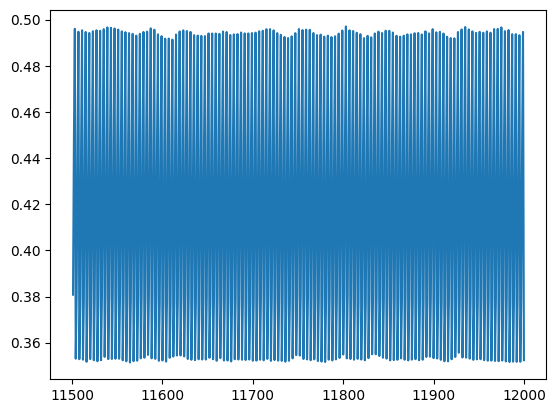

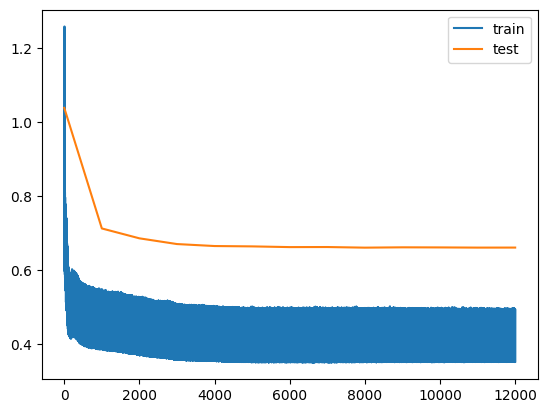

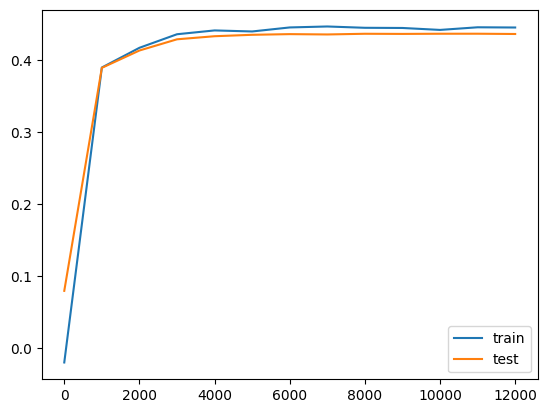

In [7]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [10]:
for idx, tr2 in enumerate(results["test_r2s"]):
    tra_r2 = results["train_r2s"][idx]
    print(tra_r2, tr2)
print(results["final_test_r2"])

(0, -0.13110137270763517) (0, -0.06069350428879261)
(1000, 0.32466738149523733) (1000, 0.31211113929748535)
(2000, 0.34811592280864717) (2000, 0.3300124853849411)
(3000, 0.3668984803557396) (3000, 0.3438854515552521)
(4000, 0.37607586596161124) (4000, 0.3512279987335205)
(5000, 0.38115322204306723) (5000, 0.3559885323047638)
(6000, 0.3712105279415846) (6000, 0.3501007854938507)
(7000, 0.357153063416481) (7000, 0.33363670110702515)
(8000, 0.36797647178173065) (8000, 0.3474976420402527)
(9000, 0.3752517929673195) (9000, 0.3544057458639145)
(10000, 0.3662481471896172) (10000, 0.3422957509756088)
(11000, 0.3719416007399559) (11000, 0.35247354209423065)
(12000, 0.3735421054065228) (12000, 0.35132357478141785)
0.3509666472673416


tensor([-0.7666, -0.7184, -0.7380, -0.8264, -0.7874, -0.8372, -0.7959, -0.8899,
        -0.8641, -0.9166], device='cuda:0')
------
------
tensor([-0.1010,  0.0807, -0.1958, -0.1517, -0.0279, -0.3650, -0.0769,  0.1464,
        -0.0789, -0.1700], device='cuda:0') tensor([ 0.2100, -0.0737,  0.2755,  0.3298,  0.0255,  0.6256,  0.0668, -0.2502,
         0.0782,  0.2572], device='cuda:0')
tensor([-0.7141, -0.6830, -0.7208, -0.7207, -0.7559, -0.7524, -0.7660, -0.8404,
        -0.7881, -0.7904], device='cuda:0')


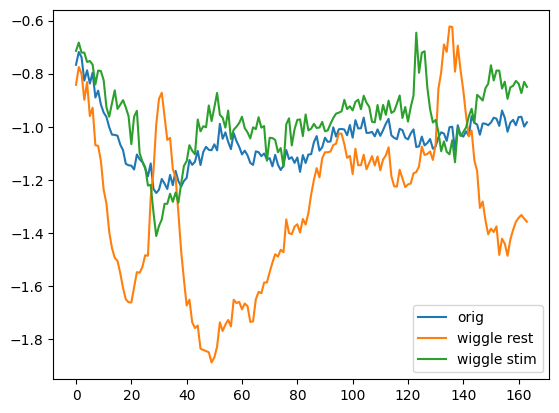

In [12]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -1.5
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

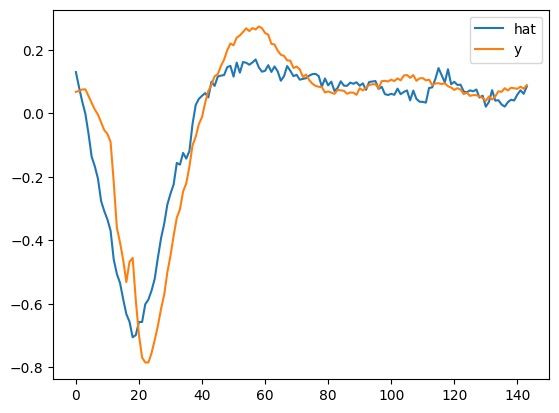

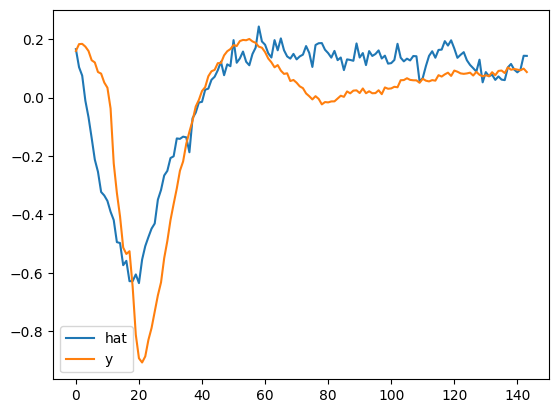

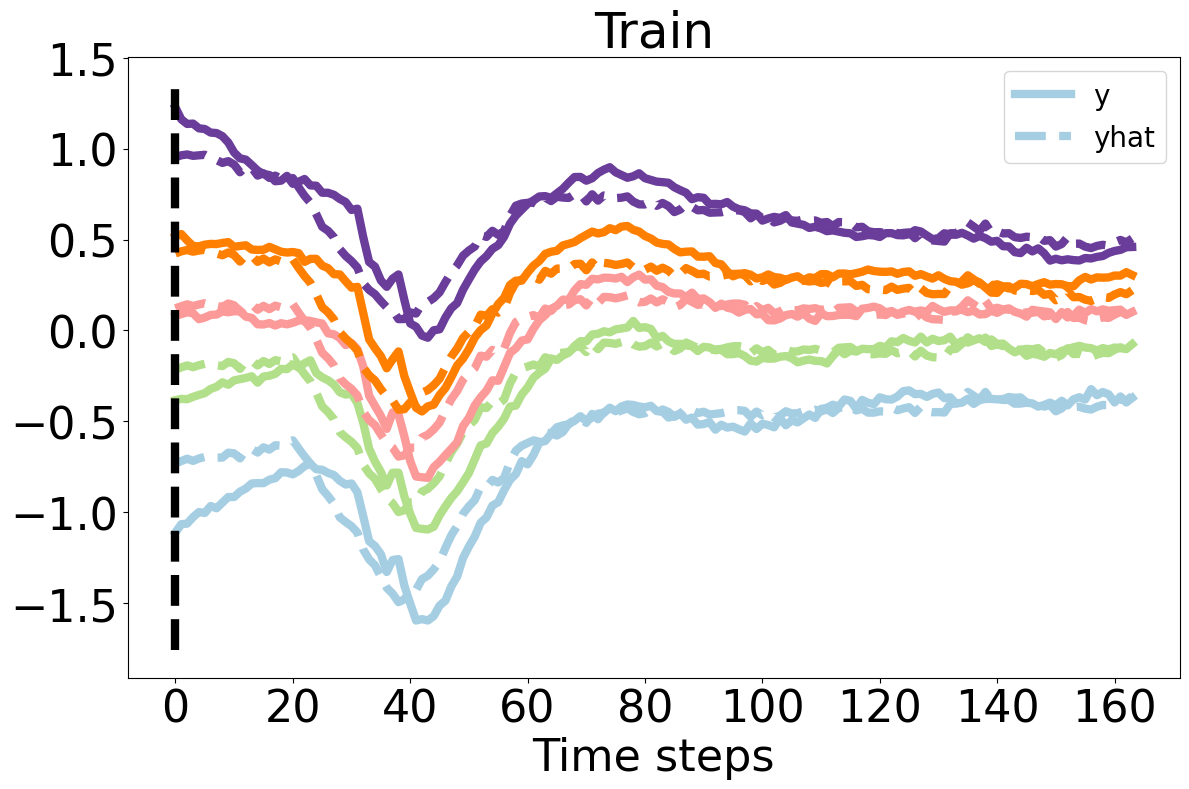

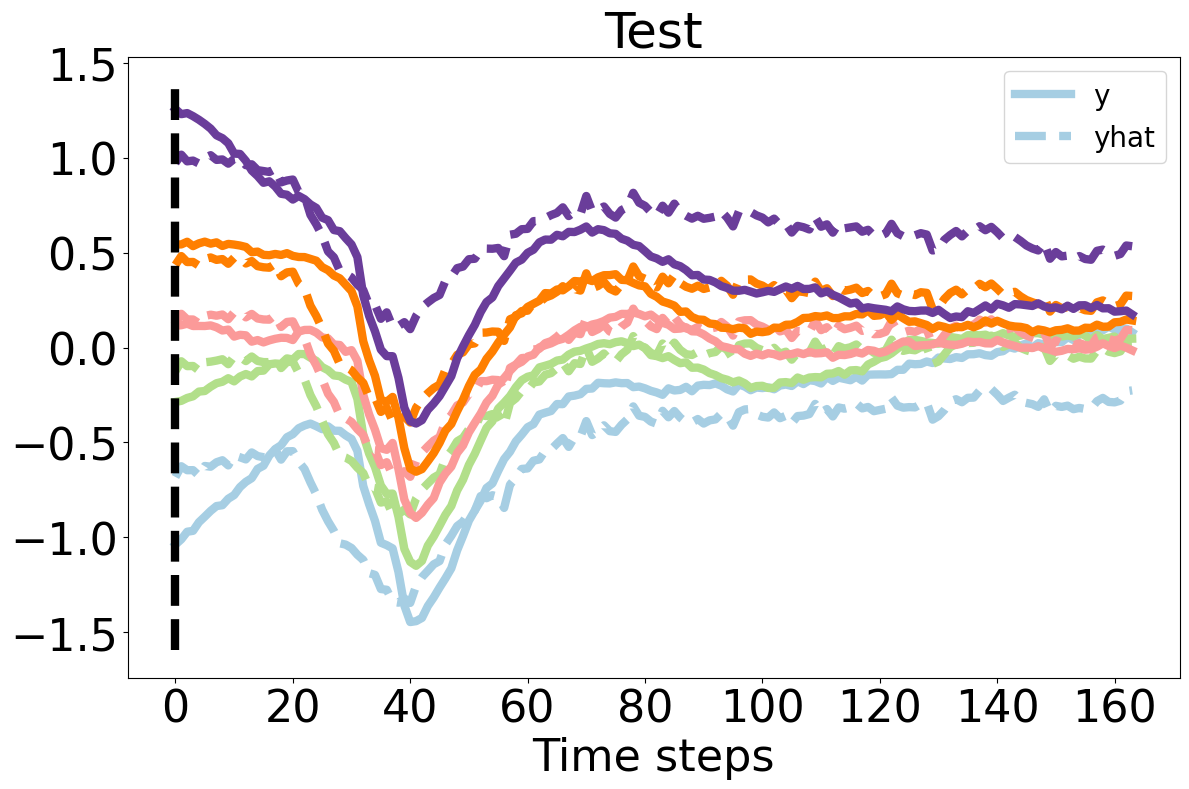

In [13]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)
    plt.show()
    
# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)
graph_for_sid('MonkeyJ_20160426_Session3_S1', results)

In [14]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=2000, data_test=data_test)
print(results_tta["final_test_r2s"])

TTA: Training data filtered: 29872/31250 trials kept
0 0.4878453314304352
100 0.4035550355911255
200 0.403444766998291
300 0.4032452404499054
400 0.40315601229667664
500 0.4032016396522522
600 0.403258740901947
700 0.40320131182670593
800 0.40309038758277893
900 0.4030800461769104
1000 0.4031440317630768
1100 0.403005450963974
1200 0.40304791927337646
1300 0.4029485881328583
1400 0.40290728211402893
1500 0.4028479754924774
1600 0.4027290344238281
1700 0.40285566449165344
1800 0.40272802114486694
1900 0.40288954973220825
TTA: Test data filtered: 59672/62500 (95.5%)
{'MonkeyG_20150914_Session1_S1': 0.34862610697746277, 'MonkeyG_20150915_Session2_S1': 0.40207116305828094, 'MonkeyG_20150915_Session3_S1': 0.4321378320455551, 'MonkeyG_20150915_Session4_S1': 0.39794331789016724, 'MonkeyG_20150917_Session1_M1': 0.125261552631855, 'MonkeyG_20150917_Session2_M1': 0.1273535005748272, 'MonkeyG_20150917_Session3_M1': 0.1337515451014042, 'MonkeyG_20150917_Session3_S1': 0.7492504715919495, 'MonkeyG_2

tensor([-1.0656, -1.0921, -1.1008, -1.0893, -1.1119, -1.0958, -1.1129, -1.0636,
        -1.0881, -1.0625], device='cuda:0')
------
tensor([ 0.6824, -0.0798,  0.0786,  0.0104, -0.2693,  0.7660,  0.9348,  0.7890,
        -0.1188,  0.6611], device='cuda:0') tensor([-1.1765,  0.2374, -0.1255, -0.0135,  0.3549, -1.6499, -2.6113, -2.0025,
         0.3338, -0.9485], device='cuda:0')
tensor([-1.0593, -1.0593, -1.0758, -1.0647, -1.0892, -1.0787, -1.0739, -1.0704,
        -1.0601, -1.0551], device='cuda:0')


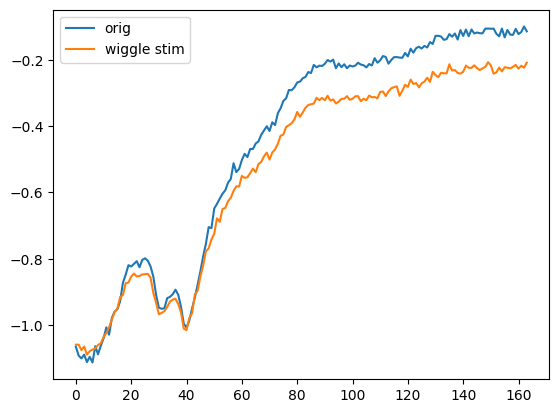

In [11]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    # preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    # plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    # print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(new_stim_embeddings, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

Filtered 126 outlier trials
torch.Size([824, 164, 77]) torch.Size([1120, 164, 77]) torch.Size([824, 164, 77]) torch.Size([1120, 164, 77]) torch.Size([1120, 164, 77]) torch.Size([824, 164, 77])


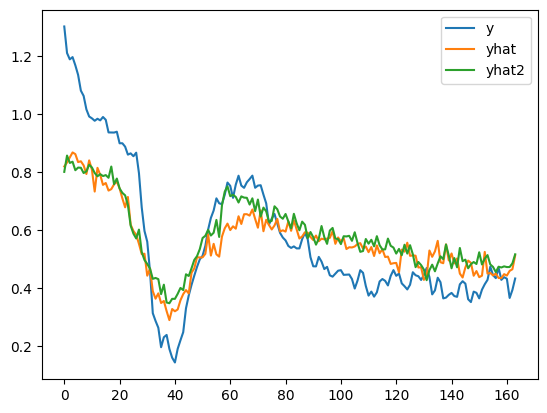

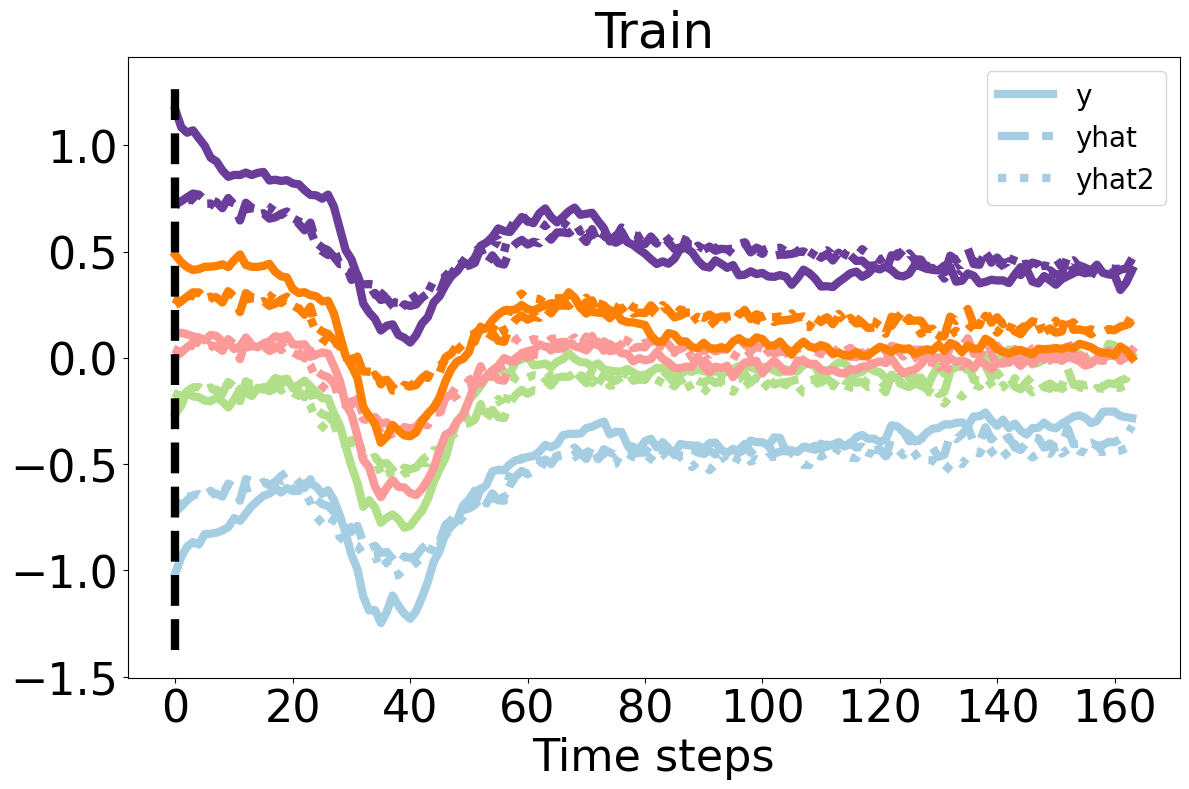

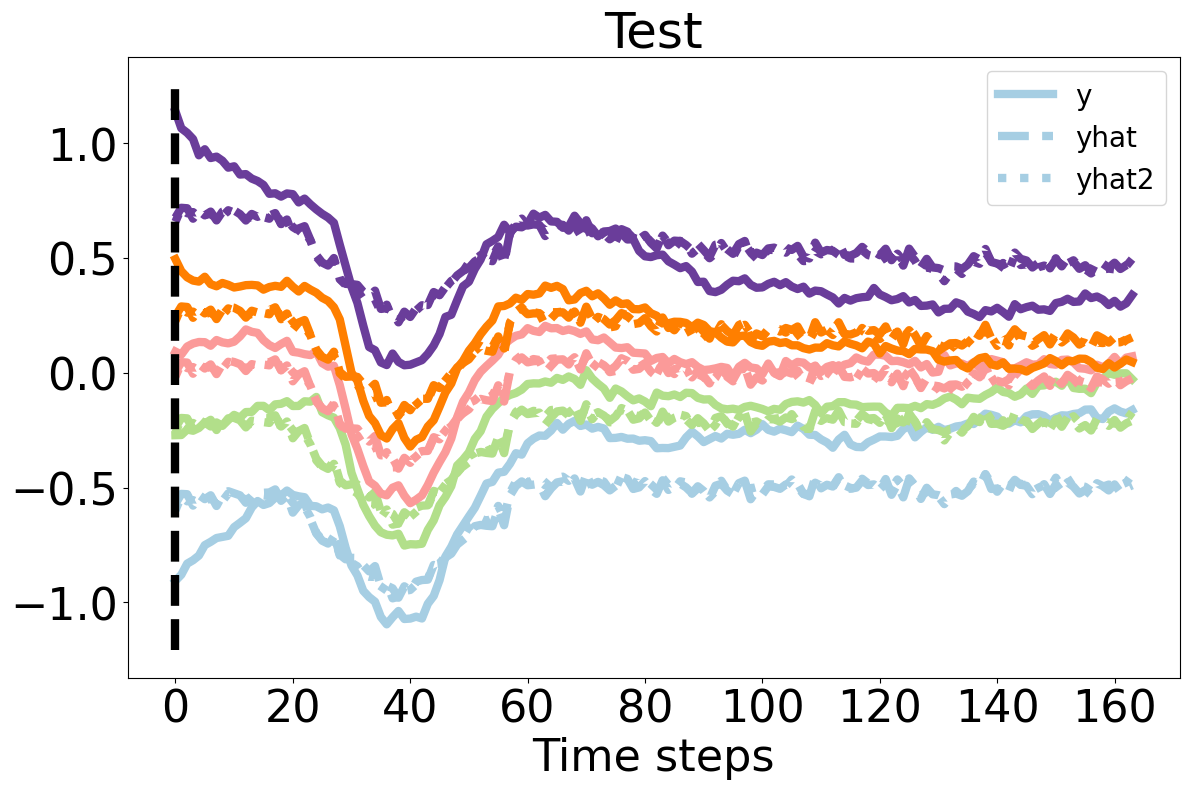

In [15]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)

        
        # Apply outlier filtering to match training behavior
        dt, filter_stats = utils.filter_batch_outliers(dt, model.norms, cfg)
        if cfg.training.use_outlier_filtering:
            print(f"Filtered {filter_stats['per_session'][sid][1] - filter_stats['per_session'][sid][0]} outlier trials")
            
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]
        
    print(y_hats.shape, y_hats_test.shape, y.shape, y_test.shape, y_hats_test2.shape, y_hats2.shape)

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

# graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid_tta('MonkeyJ_20160426_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)



In [21]:
print(results.keys())

dict_keys(['final_test_r2', 'final_test_r2s', 'final_test_loss', 'y_hat_test', 'y_test'])
